In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import itertools
import os
from xgboost import XGBClassifier
from aux import get_x_data, makeSubmission, plot_precision_and_recall, plot_confusion_matrix, runRandomForests

In [2]:
_PATH_DATASET = '/home/diego/Cursos/FIUBA/git/fiuba-trocafone-tp2-final-set/' # No borrar esto, por compatibilidad para correrlo con datasets en otros directorios

In [3]:
def runXGBoost(X_train, y_train, X_test, y_test, max_depth = 5, learning_rate = 0.1, n_estimators = 100,
              n_jobs = 2): #, criterion = 'gini', min_samples_split=4):
    # Creo el objeto
    xgb = XGBClassifier(n_estimators = n_estimators,
                                  max_depth = max_depth, learning_rate = learning_rate,
                                  random_state = 123, n_jobs = n_jobs)
    # Ajusto
    xgb.fit(X_train, y_train)

    # Predigo
    Y_prediction = xgb.predict(X_test)

    # Calculate the absolute errors
    errors = abs(Y_prediction - y_test)

    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    
    #random_forest.score(X_test, Y_prediction)
    acc_xgb = round(xgb.score(X_test, Y_prediction) * 100, 2)
    print(round(acc_xgb,2,), "%")
    return xgb


## Cargo los features

In [4]:
# Cargo los features para entrenamiento
new_vector_features = pd.read_csv(_PATH_DATASET + 'out_features_processed_train.csv')
new_vector_features = new_vector_features.set_index('person')

# Cargo los features para predicción
new_vector_features_to_predict = pd.read_csv(_PATH_DATASET + 'out_features_processed_to_predict.csv')
new_vector_features_to_predict = new_vector_features_to_predict.set_index('person')

to_submit = pd.read_csv(_PATH_DATASET + 'trocafone_kaggle_submit_sample_all_0.csv')

In [5]:
# Muy importante!!! Igual lo estoy haciendo en la predicción
new_vector_features_to_predict = new_vector_features_to_predict.reindex(to_submit.person)

> # Separación de test de entrenamiento y pruebas

In [6]:
cols = {'label':True, 'first_inter_to_june': True} # Elimino los false
# Borro los menos significativos
#cols = {
#    'Computer': False, 'Smartphone': False, 'Tablet': False, 'Unknown': False}


In [7]:
x_data, y_labels = get_x_data(new_vector_features, cols)
x_features_to_predict, y_labels_to_predict = get_x_data(new_vector_features_to_predict, cols)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.1,random_state=101)

In [8]:
new_vector_features.head()

,label,timeDelta,last_inter_to_june,first_inter_to_june,interactions,isNotWeekend,isWeekend,isFortnite,isNotFortnite,month1,...,channel_Social,channel_Unknown,device_type_Computer,device_type_Smartphone,device_type_Tablet,device_type_Unknown,perc_computer,perc_tablet,perc_smartphone,perc_unknown
person,,,,,,,,,,,,,,,,,,,,,
0566e9c1,0,772618.0,26916.0,799534.0,68,5,63,68,0,0,...,0,0,0,17,0,0,0.0,0.0,1.0,0.0
6ec7ee77,0,0.0,336876.0,336876.0,2,0,2,2,0,0,...,0,0,0,1,0,0,0.0,0.0,1.0,0.0
abe7a2fb,0,9335392.0,174046.0,9509438.0,96,32,64,32,64,0,...,2,0,0,22,0,0,0.0,0.0,1.0,0.0
34728364,0,742549.0,388950.0,1131499.0,37,4,33,37,0,0,...,0,0,0,4,0,0,0.0,0.0,1.0,0.0
87ed62de,0,1409.0,1123199.0,1124608.0,17,1,16,17,0,0,...,0,0,1,0,0,0,1.0,0.0,0.0,0.0


> # Hago distintas pruebas

In [9]:
# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

## XGBoost


In [ ]:
from sklearn.grid_search import GridSearchCV   #Perforing grid search
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/home/diego/.local/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/diego/.local/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [51]:
# Random Forest
n_estimators = 500
xgb = runXGBoost(X_train, y_train, X_test, y_test, n_estimators = n_estimators)#, criterion='entropy')
y_prediction = xgb.predict(X_test)

Mean Absolute Error: 0.06 degrees.
100.0 %


In [52]:
# predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
# cnf_matrix = confusion_matrix(y_test, predictions)
# class_names = ['0', '1']
# #plt.figure(figsize=(14, 7))
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

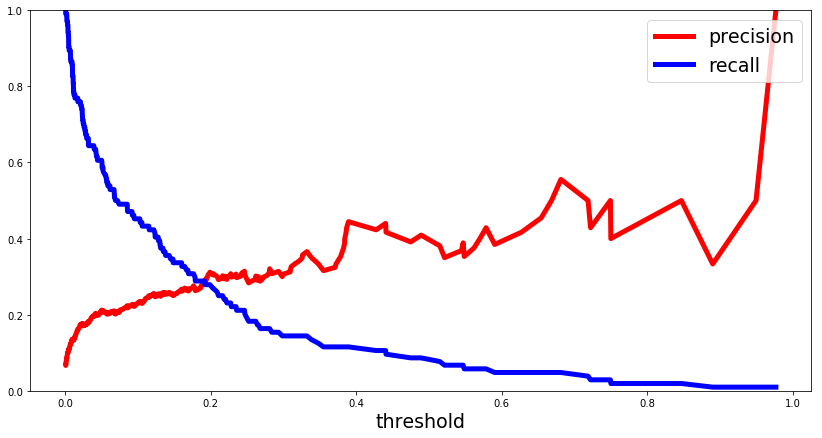

In [53]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = xgb.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

In [54]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(xgb.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
timeDelta,0.046
storage_var,0.045
first_inter_to_june,0.044
storage_mean,0.044
cond_mean,0.039
june_to_last_search engine hit,0.039
june_to_last_checkout,0.039
june_to_last_ad campaign hit,0.036
cond_var,0.034


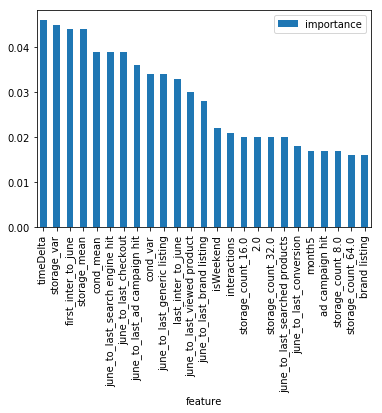

In [55]:
#plt.figure()
plt.figure(figsize=(14, 7))
importances[:25].plot.bar()
plt.show()

In [56]:
y_test_pred = xgb.predict_proba(X_test)

In [57]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_test_pred[:,1])

0.84552084205239808

In [62]:
# RoC AuC, es la que puntúa kaggle
thres = 0.035
roc_auc_score(y_test, (y_test_pred[:, 1]>thres).astype(int))

0.74376935632376329

In [25]:
# Calculo el score medio
random_forest.score(X_test, y_test)

0.94541709577754895

In [26]:
sum(y_train) + sum(y_test)

980

In [27]:
sum(y_test)

104

In [28]:
sum(y_test_pred[:,1]>thres)

429

In [29]:
y_pred_to_predict = random_forest.predict_proba(x_features_to_predict)
ts = makeSubmission(y_pred_to_predict, to_submit, thres)

In [30]:
ts.to_csv('estima40porciento.csv')

In [31]:
fin

NameError: name 'fin' is not defined

### Vuelvo a realizar RandomForests con menos features

In [ ]:
y_scores_predicted = random_forest.predict_proba()

In [ ]:
y_labels_to_predict.head()

In [42]:
# Borro los menos significativos
cols = {
    'month4': False, '1.0': False, 'month3': False, 'conversion': False, 'staticpage': False, 'month1': False,
    'month2': False, '5.0': False, 'lead': False}

In [43]:
x_data, y_labels = get_x_data(new_vector_features, cols)
x_features_to_predict, y_labels_to_predict = get_x_data(new_vector_features_to_predict, cols)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.3,random_state=101)

In [44]:
x_data.columns

Index(['timeDelta', 'last_inter_to_june', 'first_inter_to_june',
       'interactions', 'isNotWeekend', 'isWeekend', 'isFortnite',
       'isNotFortnite', 'month5', 'ad campaign hit', 'brand listing',
       'checkout', 'generic listing', 'search engine hit', 'searched products',
       'viewed product', 'visited site', '2.0', '3.0', '4.0', 'cond_var',
       'cond_mean'],
      dtype='object')

In [46]:
# Vuelvo a crear el objeto random_forest
# Random Forest
n_estimators = 50
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


Confusion matrix, without normalization
[[5518   11]
 [ 294    2]]


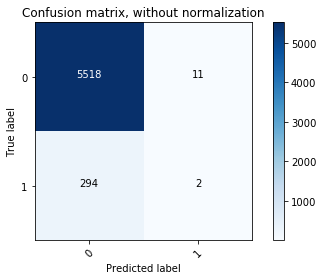

In [47]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

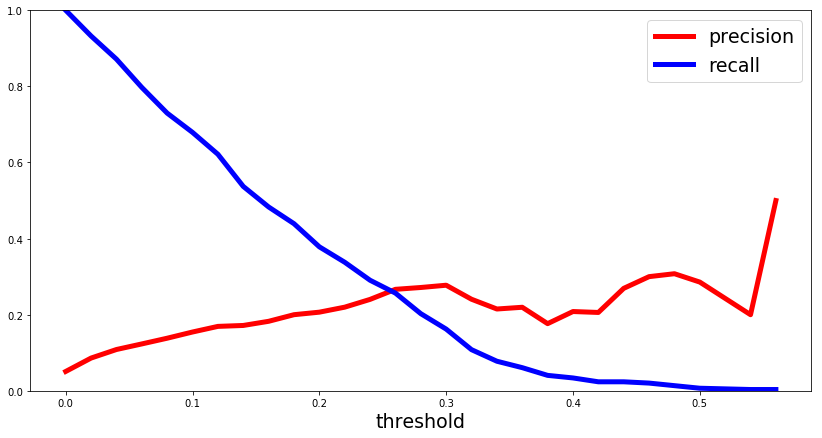

In [48]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

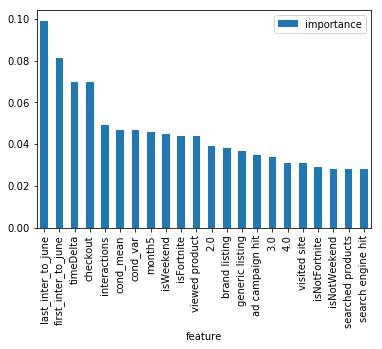

In [49]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
#plt.figure()
importances.plot.bar()
plt.show()

In [50]:
# Vuelvo a crear el objeto random_forest
# Random Forest
n_estimators = 150
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


Confusion matrix, without normalization
[[5519   10]
 [ 295    1]]


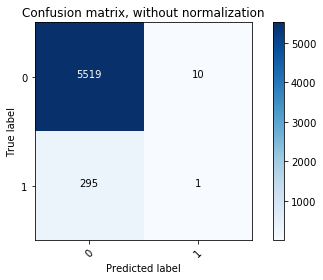

In [51]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

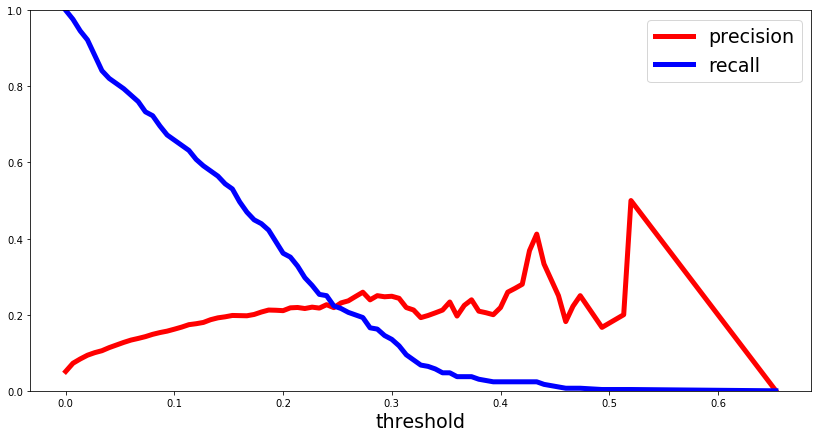

In [52]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

In [53]:
# Vuelvo a crear el objeto random_forest
# Random Forest
n_estimators = 50
random_forest = runRandomForests(X_train, y_train, X_test, y_test, n_estimators = n_estimators)
y_prediction = random_forest.predict(X_test)

Mean Absolute Error: 0.05 degrees.
100.0 %


Confusion matrix, without normalization
[[5519   10]
 [ 291    5]]


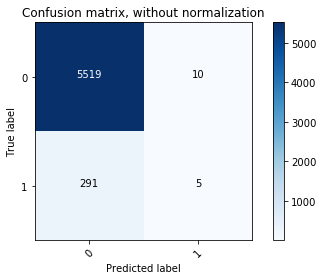

In [54]:
predictions = cross_val_predict(random_forest, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

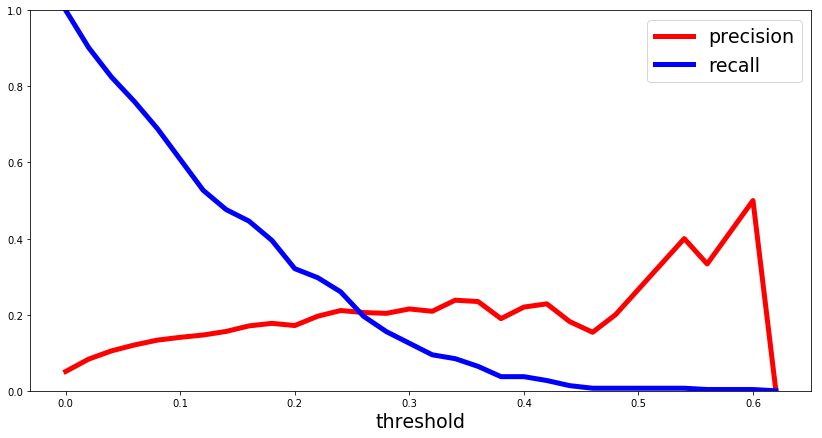

In [55]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = random_forest.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

## Pruebo con PCA

In [155]:
from sklearn.decomposition import PCA

In [156]:
cols = {}
x_data, y_labels = get_x_data(new_vector_features, cols)
x_features_to_predict, y_labels_to_predict = get_x_data(new_vector_features_to_predict, cols)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data,y_labels,test_size=0.3,random_state=101)

In [157]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

In [158]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test)

In [159]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=50, random_state=0)  
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)  

Confusion matrix, without normalization
[[5515   14]
 [ 289    7]]


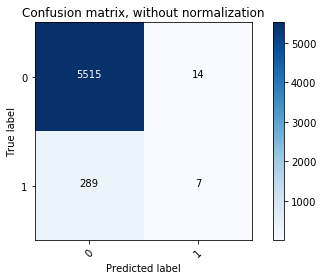

In [160]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)  
#print(cm)  
#print('Accuracy' + accuracy_score(y_test, y_pred))
class_names = ['0', '1']
# plt.figure(figsize=(14, 7))
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

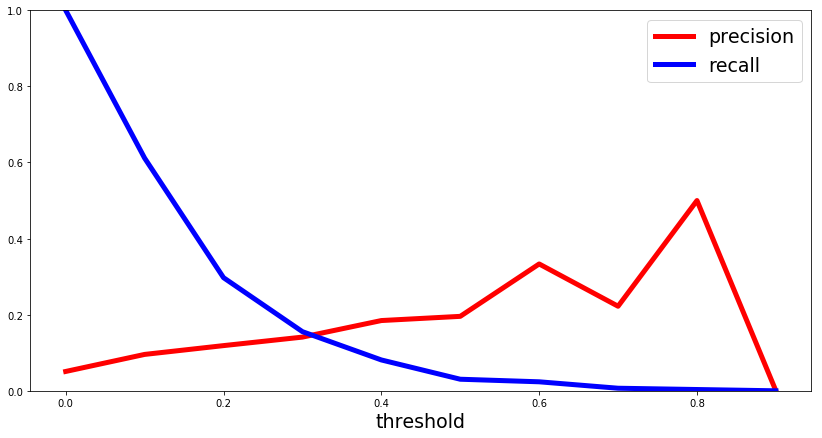

In [161]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores_orig = classifier.predict_proba(X_test)
y_scores = y_scores_orig[:,1]
#y_scores = (y_scores_orig [:,1] >= threshold1).astype('int')
#Si no hay ningún 1 da Warning y no se plotea nada
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)

In [56]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_test, Y_pred) * 100, 2)
print(round(acc_log,2,), "%")



100.0 %


In [57]:
predictions = cross_val_predict(logreg, X_test, y_test, cv=3)
cnf_matrix = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[5529    0]
 [ 296    0]]


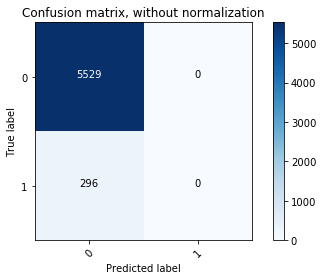

In [58]:
class_names = ['0', '1']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')